In [1]:
from collab_v1.data_higgs import load_data, download_and_make_data
import pandas as pd
from sklearn.feature_selection import SelectFromModel
import tensorflow as tf

from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from solution import get_training_data, train_catboost, train_dnn, draw_loss, roc_plots, normal_model, overfitting_model
import numpy

2025-07-10 01:50:58.067041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752105058.229425   80141 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752105058.269082   80141 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752105058.621238   80141 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752105058.621275   80141 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752105058.621278   80141 computation_placer.cc:177] computation placer alr

In [2]:
# download_and_make_data()
dataset = load_data()
X_train, y_train, X_val, y_val = get_training_data(dataset)
print(X_train.head())
print("SHAPE", X_train.shape, X_val.shape)
dataset.close()

Loading /home/luka/Documents/Programming/school/mp/ml/data/higgs-parsed/higgs-parsed.h5...
Loaded.
   lepton-pT  lepton-eta  lepton-phi  missing-energy  missing-energy-phi  \
0   1.138683   -0.726635   -0.005790        0.204118            0.153842   
1   0.404633    1.014821   -1.050041        1.136441           -1.403536   
2   1.137585    0.325251    1.453598        0.804114            0.893516   
3   1.380438   -0.595149   -0.727112        0.465392           -0.057453   
4   0.962628    1.191110   -1.161568        1.541759            0.569159   

   jet_1-pt  jet_1-eta  jet_1-phi  jet_1-b-tag  jet_2-pt  ...  jet_4-eta  \
0  1.585904  -0.045576  -1.448527     1.086538  1.598471  ...  -2.439800   
1  3.218436  -1.944837   0.801788     0.000000  2.238942  ...  -1.174742   
2  0.418095  -1.164536  -0.585919     0.000000  0.653565  ...   0.280201   
3  0.399224  -0.076273   1.080084     2.173076  0.644878  ...   1.261267   
4  1.337374   0.810973   0.458075     1.086538  0.549946  ...   

In [3]:
def get_model_v0(shape):
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Input(shape=shape,),

            tf.keras.layers.Dense(50, activation="relu"),
            tf.keras.layers.Dense(50, activation="relu"),

            tf.keras.layers.Dense(1, activation="sigmoid"),
        ]
    )
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["auc", "accuracy"])

    return model



def get_model_v1(shape):
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Input(shape=shape,),
            tf.keras.layers.BatchNormalization(),

            tf.keras.layers.Dense(256, use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation("relu"),
            tf.keras.layers.Dense(128, use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation("relu"),
            tf.keras.layers.Dropout(0.3),


            tf.keras.layers.Dense(64, use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation("relu"),
            tf.keras.layers.Dense(64, use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation("relu"),
            tf.keras.layers.Dropout(0.3),

            tf.keras.layers.Dense(1, activation="sigmoid"),
        ]
    )
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["auc", "accuracy"])

    return model

def get_autoencoder(input_shape, encoding_dim=15):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Encoder
    x = tf.keras.layers.BatchNormalization()(inputs)
    x = tf.keras.layers.Dense(50)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)


    x = tf.keras.layers.Dense(encoding_dim)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    encoded = tf.keras.layers.Activation("relu")(x)

    
    # Decoder (mirror of encoder)
    x = tf.keras.layers.Dense(50)(encoded)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    decoded = tf.keras.layers.Dense(input_shape[0], activation='sigmoid')(x)
    
    # Models
    autoencoder = tf.keras.Model(inputs, decoded)
    encoder = tf.keras.Model(inputs, encoded)
    
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder


def get_model_v2(shape, X_train):
    autoencoder, encoder = get_autoencoder(shape)
    autoencoder.fit(X_train, X_train, epochs=5)
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Input(shape=shape,),
            encoder,
            tf.keras.layers.BatchNormalization(),

            tf.keras.layers.Dense(256, use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation("relu"),
            tf.keras.layers.Dense(128, use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation("relu"),
            tf.keras.layers.Dropout(0.1),

            tf.keras.layers.Dense(100, use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation("relu"),
            tf.keras.layers.Dense(100, use_bias=False),
            tf.keras.layers.Activation("relu"),

            tf.keras.layers.Dense(1, activation="sigmoid"),
        ]
    )
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["auc", "accuracy"])

    return model


def get_model_v3(shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(300,
            kernel_initializer='random_normal',
            kernel_regularizer=tf.keras.regularizers.l2(1e-5),
            input_shape=shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation("tanh"),
        tf.keras.layers.Dense(300,
            kernel_initializer='random_normal',
            kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation("tanh"),
        tf.keras.layers.Dense(300, 
            kernel_initializer='random_normal',
            kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation("tanh"),
        tf.keras.layers.Dense(300, 
            kernel_initializer='random_normal',
            kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation("tanh"),
        tf.keras.layers.Dense(1, activation='sigmoid',
            kernel_initializer='random_normal',
            kernel_regularizer=tf.keras.regularizers.l2(1e-5))
    ])
    initial_lr = 0.05
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_lr,
        decay_steps=1000,
        decay_rate=1.0000002,
        staircase=False
    )
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["auc", "accuracy"])

    return model


def train_dnn(model, X_train, y_train, x_val, y_val, epochs=20, batch_size=100, verbose=2):
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        verbose=verbose,
    )

    return history

In [ ]:
model.summary()

In [4]:
model = get_model_v2((X_train.shape[1],), X_train)
history = train_dnn(model, X_train, y_train, X_val, y_val, epochs=1000, batch_size=1_000)


2025-07-10 01:51:13.461660: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-07-10 01:51:13.461709: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-07-10 01:51:13.461715: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: fedora
2025-07-10 01:51:13.461719: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] hostname: fedora
2025-07-10 01:51:13.461846: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:197] libcuda reported version is: 575.64.0
2025-07-10 01:51:13.461872: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:201] kernel reported version

Epoch 1/5


2025-07-10 01:51:17.805819: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 560000000 exceeds 10% of free system memory.
2025-07-10 01:51:19.235072: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 40000000 exceeds 10% of free system memory.
2025-07-10 01:51:19.265167: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 40000000 exceeds 10% of free system memory.
2025-07-10 01:51:21.456783: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 40000000 exceeds 10% of free system memory.


156250/156250 ━━━━━━━━━━━━━━━━━━━━ 199s 1ms/step - loss: 0.4848
Epoch 2/5
156250/156250 ━━━━━━━━━━━━━━━━━━━━ 193s 1ms/step - loss: 0.4645
Epoch 3/5
156250/156250 ━━━━━━━━━━━━━━━━━━━━ 192s 1ms/step - loss: 0.4640
Epoch 4/5
156250/156250 ━━━━━━━━━━━━━━━━━━━━ 193s 1ms/step - loss: 0.4638
Epoch 5/5
156250/156250 ━━━━━━━━━━━━━━━━━━━━ 204s 1ms/step - loss: 0.4637
Epoch 1/1000
5000/5000 - 35s - 7ms/step - accuracy: 0.6684 - auc: 0.7312 - loss: 0.6042 - val_accuracy: 0.7084 - val_auc: 0.7863 - val_loss: 0.5567
Epoch 2/1000
5000/5000 - 32s - 6ms/step - accuracy: 0.7093 - auc: 0.7843 - loss: 0.5558 - val_accuracy: 0.7274 - val_auc: 0.8061 - val_loss: 0.5322
Epoch 3/1000
5000/5000 - 32s - 6ms/step - accuracy: 0.7167 - auc: 0.7932 - loss: 0.5465 - val_accuracy: 0.7307 - val_auc: 0.8107 - val_loss: 0.5283
Epoch 4/1000
5000/5000 - 32s - 6ms/step - accuracy: 0.7194 - auc: 0.7965 - loss: 0.5429 - val_accuracy: 0.7335 - val_auc: 0.8136 - val_loss: 0.5257
Epoch 5/1000
5000/5000 - 32s - 6ms/step - accura

15625/15625 ━━━━━━━━━━━━━━━━━━━━ 11s 698us/step
0.7975895527641021


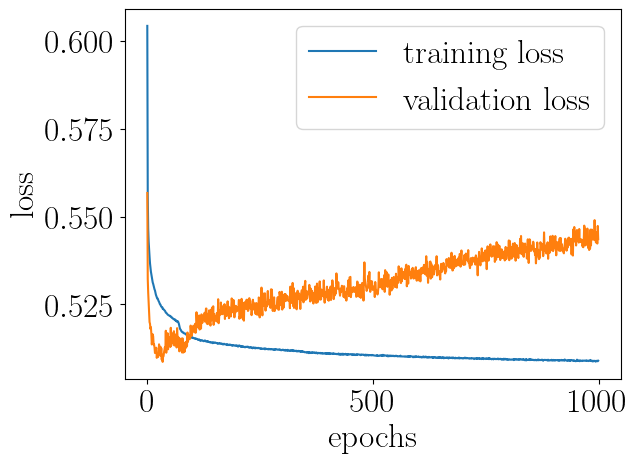

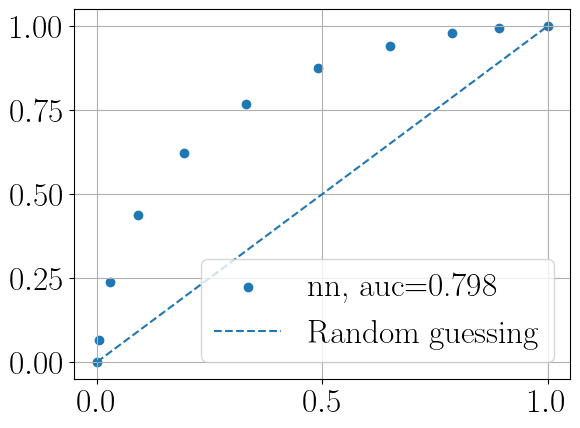

In [5]:
import numpy as np

draw_loss(history)
y_pred = model.predict(X_val)

roc_plots(y_val, (y_pred, "nn"))
print(roc_auc_score(y_val, y_pred))